In [1]:
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, gaussian_filter1d

In [2]:
data_path='/media/maria/DATA1/Documents/data_for_suite2p/TX39_total/'
dt=1
spks= np.load(data_path+'spks.npy')
print('Shape of the data matrix, neurons by timepoints:',spks.shape)
iframe = np.load(data_path+'iframe.npy') # iframe[n] is the microscope frame for the image frame n
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
S = spks[:, iframe+dt]
print(S.shape)

Shape of the data matrix, neurons by timepoints: (18795, 30766)
(18795, 30560)


In [3]:
medians=np.mean(S.T,axis=0)
S_binarized=[]
for j in range(0,18795):
    interm=S.T[:,j]
    interm[interm<=medians[j]]=0.001
    interm[interm>=medians[j]]=1
    S_binarized.append(interm)
S_binarized=np.array(S_binarized).T[:10000,:10000]
del S
del spks

In [4]:
ep=EnsemblePursuit(n_components=200,lam=0.01,n_kmeans=200)
model=ep.fit(S_binarized)
V=model.components_
U=model.weights

obtained 200 PCs in 10.4372 seconds
initialized 200 clusters with k-means in 8.3018 seconds
ensemble 0, time 4.18, nr neurons 4451, EV 0.0114
ensemble 25, time 28.40, nr neurons 95, EV 0.0329
ensemble 50, time 49.77, nr neurons 28, EV 0.0402
ensemble 75, time 71.44, nr neurons 21, EV 0.0450
ensemble 100, time 91.93, nr neurons 9, EV 0.0491
ensemble 125, time 111.89, nr neurons 14, EV 0.0530
ensemble 150, time 132.78, nr neurons 6, EV 0.0564
ensemble 175, time 152.54, nr neurons 4, EV 0.0597
ensemble 199, time 171.95, nr neurons 3, EV 0.0628
average sparsity is 0.0073


In [5]:
print(S_binarized.shape)

(10000, 10000)


In [6]:
def train_test_split(NT):
        nsegs = 20
        nt=NT
        nlen  = nt/nsegs
        ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
        itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
        itrain = np.ones(nt, np.bool)
        itrain[itest] = 0
        return itrain, itest

In [8]:
mov=np.load(data_path+'mov.npy')
mov = mov[:, :, ivalid]
Sp = V.T
Sp = zscore(Sp, axis=1)
ly, lx, nstim = mov.shape
#print(nstim)
NT = Sp.shape[1]
mov=mov[:,:,:NT]
#NT = Sp.shape[1]
NN=Sp.shape[0]
print(NT)
itrain,it


X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints
X = X-0.5 # subtract the background
X = np.abs(X) # does not matter if a pixel is black (0) or white (1)
X = zscore(X, axis=1)/NT**.5  # z-score each pixel separately
npix = X.shape[0]

lam = 0.1
ncomps = Sp.shape[0]
B0 = np.linalg.solve((X[:,itrain] @ X[:,itrain].T + lam * np.eye(npix)),  (X[:,itrain] @ Sp[:,itrain].T)) # get the receptive fields for each neuron

B0 = np.reshape(B0, (ly, lx, ncomps))
B0 = gaussian_filter(B0, [.5, .5, 0]) # smooth each receptive field a little

10000


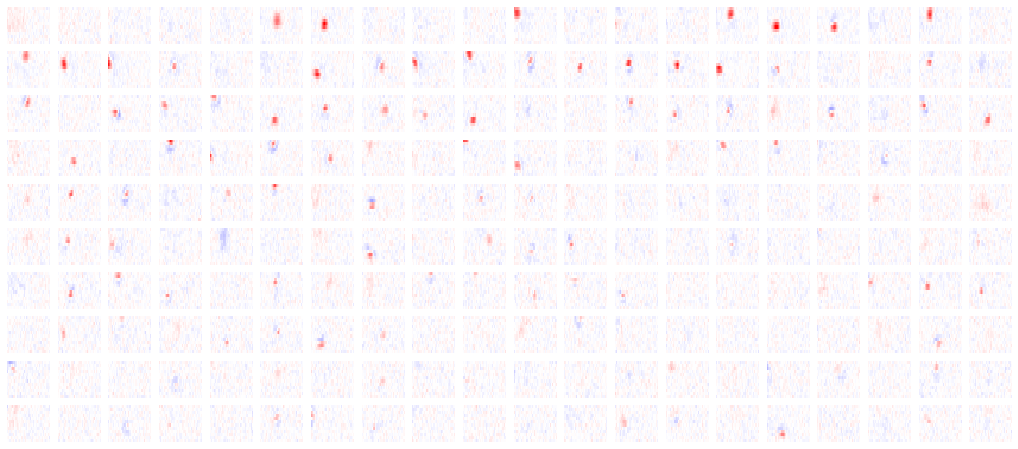

In [9]:
plt.figure(figsize=(18, 8))
rfmax = np.max(B0)
for j in range(200):
    plt.subplot(10,20,j+1)
    rf = B0[:,:,j]
    # rfmax = np.max(np.abs(rf))
    plt.imshow(rf, aspect='auto', cmap = 'bwr', vmin = -rfmax, vmax = rfmax) # plot the receptive field for each neuron
    #plt.title('PC %d'%(1+j))
    plt.axis('off')

plt.show()

In [10]:
Spred = np.reshape(B0, (-1,NN)).T @  X[:,itest]

corr_lst=[]
nr_of_components=200
for j in range(0,nr_of_components):
    corr_lst.append(np.corrcoef(Sp[j,itest],Spred[j,:])[0,1])

In [11]:
stat = np.load((data_path+'stat.npy'), allow_pickle=True) # these are the per-neuron stats returned by suite2p
# these are the neurons' 2D coordinates
ypos = np.array([stat[n]['med'][0] for n in range(len(stat))]) 
# (notice the python list comprehension [X(n) for n in range(N)])
xpos = np.array([stat[n]['med'][1] for n in range(len(stat))]) 

(array([36., 31., 51., 34., 12.,  8.,  4., 11., 10.,  3.]),
 array([  1.        ,  42.93322904,  84.86645809, 126.79968713,
        168.73291617, 210.66614521, 252.59937426, 294.5326033 ,
        336.46583234, 378.39906138, 420.33229043]),
 <a list of 10 Patch objects>)

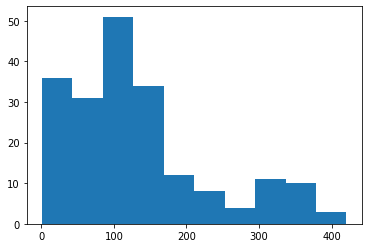

In [12]:
x_lst=[]
for comp in range(nr_of_components):
    nonz=np.nonzero(U[:,comp])[0]
    x_lst.append(np.std(xpos[nonz]))
plt.hist(x_lst)

(array([62., 76., 18.,  6.,  5.,  7., 10.,  6.,  3.,  7.]),
 array([  0.5       ,  40.00072244,  79.50144489, 119.00216733,
        158.50288977, 198.00361221, 237.50433466, 277.0050571 ,
        316.50577954, 356.00650199, 395.50722443]),
 <a list of 10 Patch objects>)

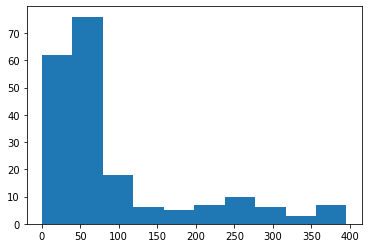

In [13]:
y_lst=[]
for comp in range(nr_of_components):
    nonz=np.nonzero(U[:,comp])[0]
    y_lst.append(np.std(ypos[nonz]))
plt.hist(y_lst)

Text(0.5, 0, 'Average spatial spread in x and y directions')

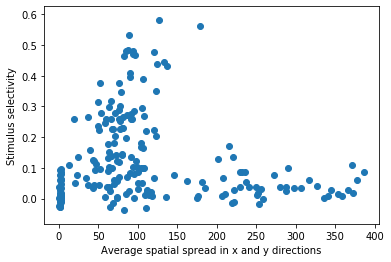

In [14]:
average_std=(np.array(x_lst)+np.array(y_lst))/2
plt.scatter(average_std,corr_lst)
plt.ylabel('Stimulus selectivity')
plt.xlabel('Average spatial spread in x and y directions')

In [15]:
proc = np.load(data_path+'cam1_TX39_2019_05_31_1_proc_resampled.npy', allow_pickle=True).item()
motSVD = proc['motSVD'][:,iframe+dt]
motSVD -= motSVD.mean(axis=1)[:,np.newaxis]
beh=motSVD[:,:10000]
covM = np.matmul(beh[:,itrain], beh[:,itrain].T)
lam = 1e5 # regularizer
covM += lam*np.eye(beh.shape[0])
A = np.linalg.solve(covM, np.matmul(beh[:,itrain], V.T[:,itrain].T))
Vpred = np.matmul(A.T, beh[:,itest])
beh_corr_lst=[]
for j in range(0,nr_of_components):
    beh_corr_lst.append(np.corrcoef(Vpred[j,:],V.T[j,itest])[0,1])

Text(0.5, 0, 'Average spatial spread in x and y directions')

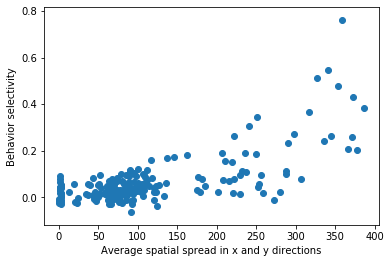

In [16]:
plt.scatter(average_std,beh_corr_lst)
plt.ylabel('Behavior selectivity')
plt.xlabel('Average spatial spread in x and y directions')

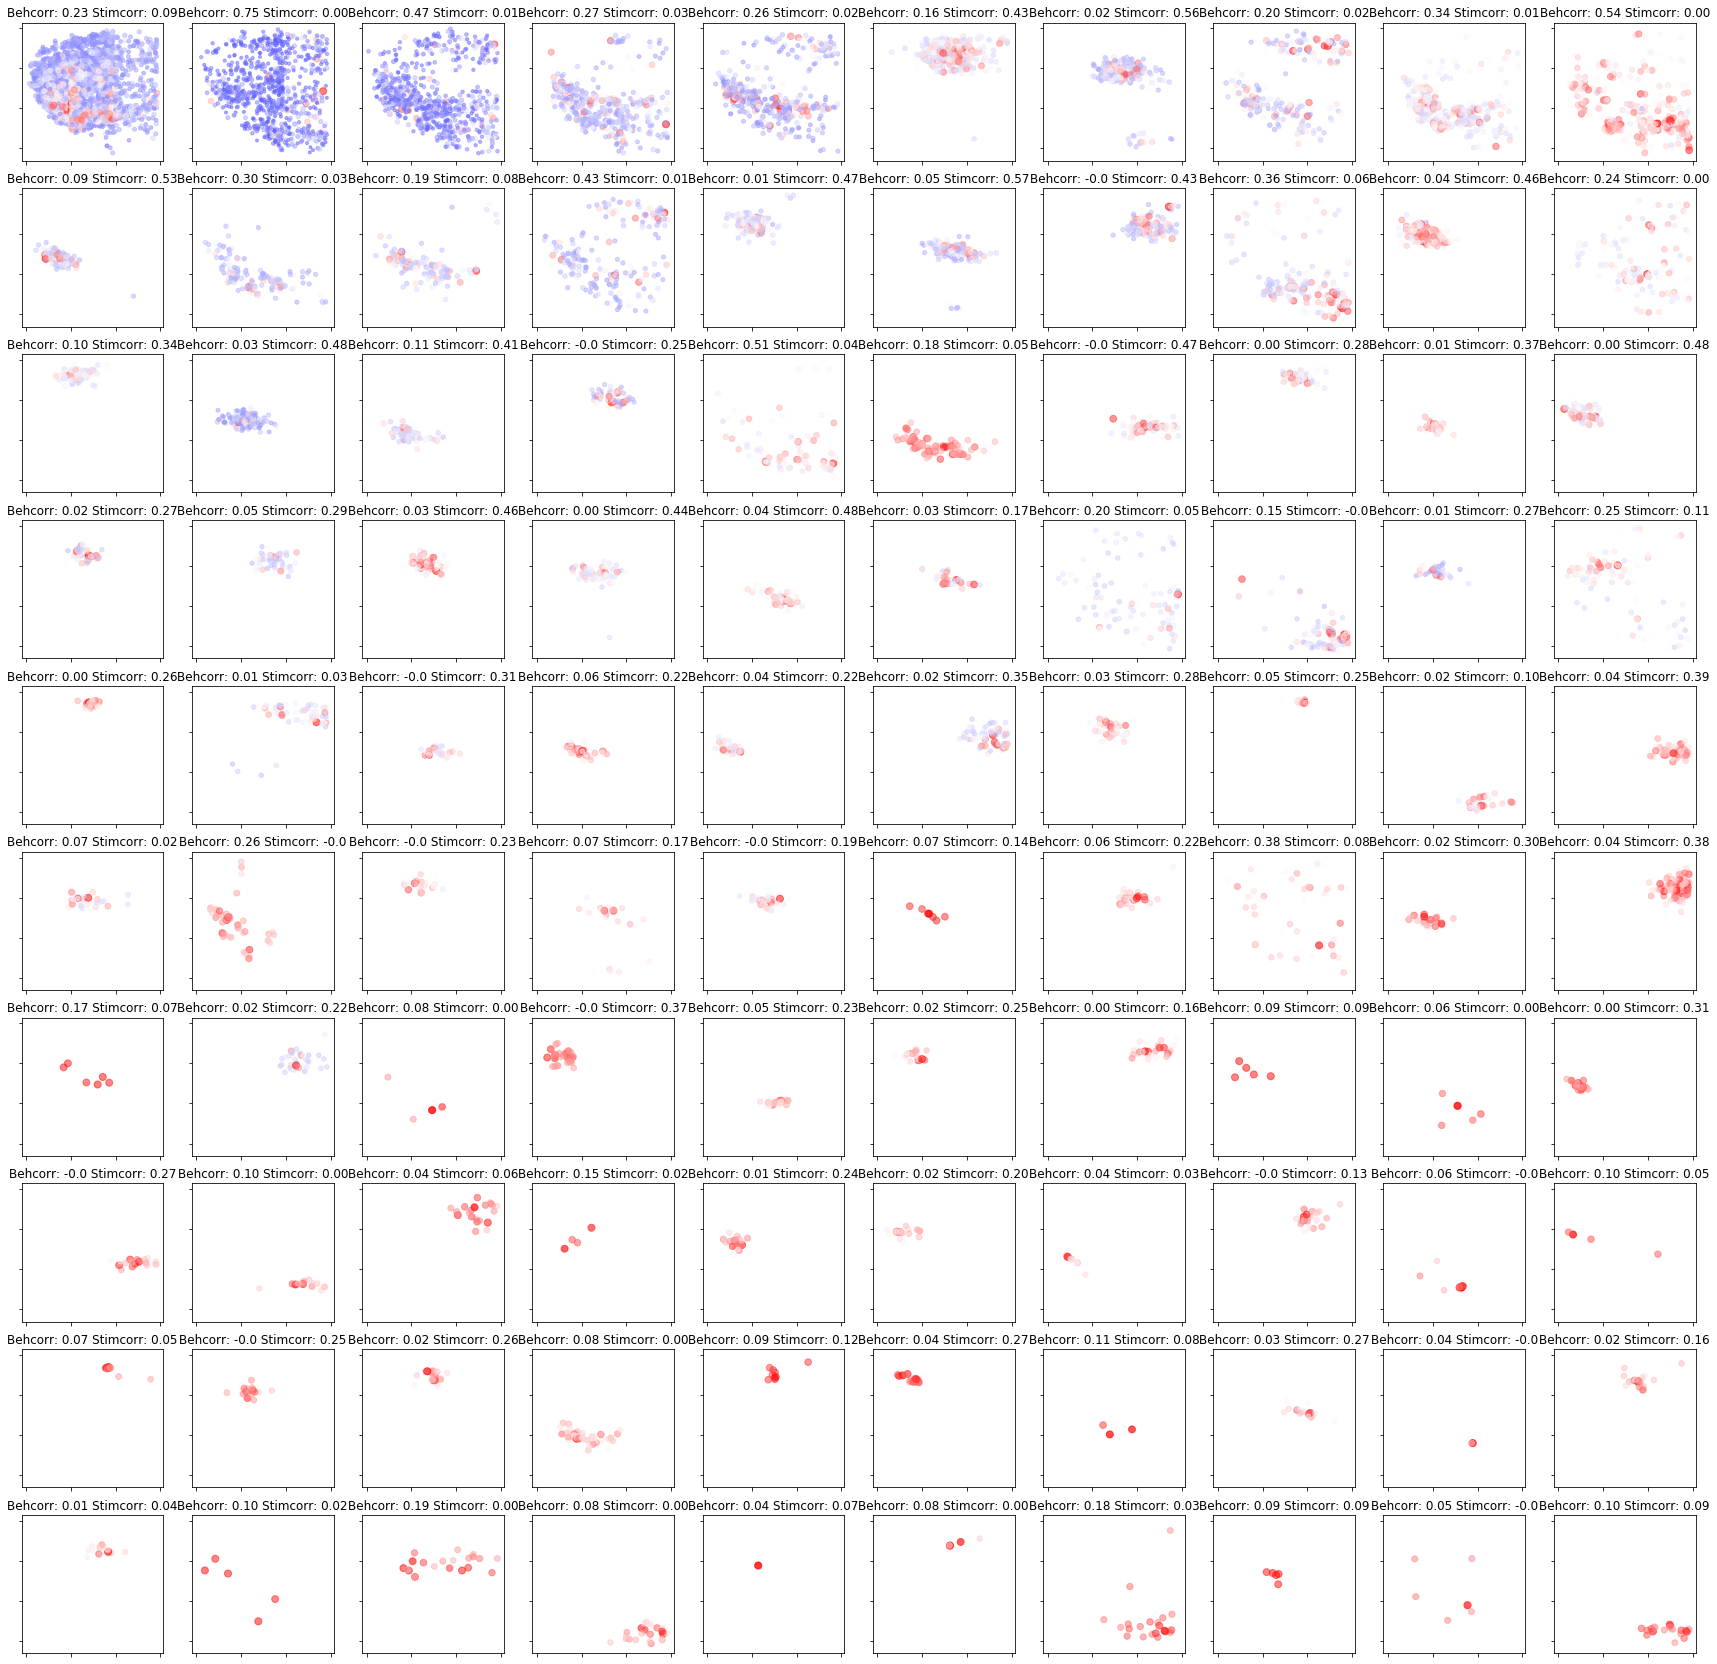

In [21]:
plt.figure(figsize=(30,30))
for j in range(100):
    comp= U[:,j]
    comp= comp/np.max(np.abs(comp))
    lam = np.abs(comp)    
    ax=plt.subplot(10,10,1+j)
    plt.scatter(xpos[:10000], -ypos[:10000], s = 50 * lam, c = comp, cmap='bwr', alpha = .5)
    plt.title('Behcorr: '+str(beh_corr_lst[j])[0:4]+' Stimcorr: '+str(corr_lst[j])[:4])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    #plt.colorbar()